# Preface

### Attribution and copyright
This analysis is based upon the Global Terrorism Database (GTD) maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism (START). Unless otherwise noted, all data used in this analysis of from the GTD:

**National Consortium for the Study of Terrorism and Responses to Terrorism (START), University of Maryland. (2018). The Global Terrorism Database (GTD) [Data file]. Retrieved from https://www.start.umd.edu/gtd**

This dataset and associated reference materials are also subject to the following copyright: **Copyright University of Maryland 2018**


### License
The author has been granted a *non-transferable* right and license to access the GTD solely for non-commercial research and analysis. Accordingly, all original data files, reference materials, and excerpts of these files or references are not included alongside the analysis. Where the author made use of direct excerpts of the data, the code to view these excerpts will be included, but the excerpts themselves will not be included.

If you have a license to access the GTD, you can re-create these excerpts by cloning this repository, installing the project requirements (you may use the `make requirements` command), placing a copy of the full GTD dataset in the `data/raw/` directory, and re-running the notebooks with the excerpt-creating code uncommented.


### Project goal
This project is undertaken with the goal of creating a machine learning system that will train on the GTD and learn to infer which terrorist group is responsible for an attack. We ultimately want to use information about terrorist attacks to predict which groups are likely suspects with as high accuracy as possible. The goal is to use this system to be able to learn something about the incidents in which the responsible group is unknown. We will limit this analysis to the data from post-1997, for reasons discussed below.


### Understanding where the data comes from
Before we begin even looking at the data itself, though, it is important to understand the process that generates the data. When teaching machines to learn from data, we must ourselves understand the biases, limitations, and corruptions that exist in the data we use to teach them. Once we understand the story of how the data came to be, we can take the necessary steps to mitigate bias or corruption in the dataset or explicitly call out these issues when using our trained learners. If we do not look into the story of the data, we will inadvertently end up teaching our machines to identify patterns that are related to the data collection methodology instead of the actual phenomenon the data was collected to measure, and our findings will be biased.


#### Data collection
According to the official codebook, the GTD consists of data collected by a number of different organizations using slightly different methodologies. The following is a table detailing the data collection timeline taken from the official codebook:

![data collection phases table](img/gtd_collection_phases.png)

This collection process gives rise to the following legacy issues (quote from the codebook):

*Legacy issues – The GTD now includes incidents of terrorism from 1970 to 2017, however a
number of new variables were added to the database beginning with the post-1997 data
collection effort. Wherever possible, values for these new variables were retroactively coded
for the original incidents, however some of the new variables pertain to details that were not
recorded in the first phase of data collection.*

In the analysis of this dataset, we must be very congnizant of the possibility of inconsistencies over time. For one, **I have decided to restrict this analysis to the post-1997 timeframe to mitigate some of these issues and also focus on a more meaningful, current timeframe**, but even after 1997 there are three different major organizations running the data collection process we should watch out for.

#### Single incident determination
Another potential "gotcha" called out by the codebook is "single incident determination." For the purposes of the GTD, different stages of a single terrorist plot that do not occur in the same geographic and temporal point will be considered as separate incidents. For example, if simultaneous attacks are carried out in different locations in the same city, or follow-up attacks are carried out against first responders, each incident is considered to be a separate record.

This is meaningful to us since we may want to train a learner on one set of data and then test it on a a separate out-of-sample set of data, and if we are not careful we may end up violating the out-of-sample property by including highly-related incidents in the test set. **An easy way to make this mistake would be to engage in uniform sampling for the purpose of performing a train-test split**, and to mitigate this potential issue we will choose to sample by date ranges or implement custom logic around the "related incidents" information contained in the dataset when splitting the dataset into a train set and a test set.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import missingno
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# set up a clean plotting style
sns.set_style('whitegrid')

# make figures a little high-res (and larger in Jupyter)
plt.rc('figure', dpi=120)

In [3]:
SEED = 0

# Import
Now that we have read up on our data, it's time to import it. Using the codebook, we investigate which features are irrelevant/redundant for machine learning, which values should be re-encoded as NaNs, and which columns need to be processed into a more meaningful representation for use in a Pandas dataframe.

### Import steps
0. Define columns of interest and their data types. Also deal with NaN encoding. This was largely a common-sense process based upon the codebook that accompanies the dataset.
  * NOTE: I ultimately forwent importing true/false data as boolean type, because in a number of these fields there are missing/blank values that are not properly documented in the codebook. Numpy/Pandas does not allow for missing values in boolean fields, so at import Pandas will silently re-encode anything that isn't exactly equal to "False" as "True", making for a sticky situation when the value is blank or missing! Using the categorical variable type insead allows us to be certain that we don't run into this problem.
* Import the chosen columns as a Pandas dataframe (using the datatype matching and NaN encoding defined in step 0).
* Convert the date into a Pandas datetime.
* Filter to post-1997. This is discussed above under the heading "data collection".
* Clean up categorical column names.

In [4]:
# CODE TO PREP IMPORTS

def process_date(df):
    """Converts the date to Pandas format.
    
    NOTE: If month or day is unknown, defaults to Jan / 01.
    """
    date_column_names = ['iyear', 'imonth', 'iday']
    date_column = pd.to_datetime(df
                                 [date_column_names]
                                 .replace(0, 1)
                                 .rename(columns=lambda name: name[1:]))
    df.insert(0, 'date', date_column)
    df.drop(columns=date_column_names, inplace=True)
    
def filter_post_1997(df):
    """Drops all rows from before 1998"""
    df.drop(df[df['date'].lt('1998')].index, inplace=True)

def fix_categorical_names(df):
    """Removes the _txt suffix from categorical variable names."""
    def strip_txt_suffix(field_name):
        if field_name[-4:] == '_txt':
            return field_name[:-4]
        else:
            return field_name
    df.rename(columns=strip_txt_suffix, inplace=True)

# we convert these sentinel values to np.nan
na_values = {
    'doubtterr': -9,
    'nperps': [-9, -99],
    'nperpcap': [-9,-99],
    'compclaim': -9,
    'property': -9,
    'ishostkid': -9,
    'nhostkid': -99,
    'nhostkidus': -99,
    'nhours': [-9, -99],
    'ndays': [-9, -99],
    'ransomamt': [-9, -99],
    'ransomamtus': [-9, -99],
    'ransompaid': [-9, -99],
    'ransompaidus': [-9, -99],
    'propvalue': -99,
    'nreleased': -99,
    'INT_LOG': -9,
    'INT_IDEO': -9,
    'INT_MISC': -9,
}

# defines the data we import and how we import it
dtype = {
    # id and date
    'eventid': 'int64',
    'iyear': 'int64',
    'imonth': 'int64',
    'iday': 'int64',
#     'approxdate': 'object',
    
    # was the incident extended?
    'extended': 'category',
    # this doesn't convert nicely into a duration measurement
    # so we'll ignore it
#     'resolution': 'datetime64[ns]',    
    
    # location
#     'country': 'int64',
    'country_txt': 'category',
#     'region': 'int64',
    'region_txt': 'category',
    'provstate': 'object',
    'city': 'object',
#     'latitude': 'float64',
#     'longitude': 'float64',
#     'specificity': 'float64',
    'vicinity': 'category',
    'location': 'object',
    
    # description of incident
    'summary': 'object',  # ONLY POST 1997
    'crit1': 'category',
    'crit2': 'category',
    'crit3': 'category',
    'doubtterr': 'category',
    'alternative_txt': 'category',
    'multiple': 'category',
    'related': 'object',
    
    # attack type
    'success': 'category',
    'suicide': 'category',
#     'attacktype1': 'int64',
    'attacktype1_txt': 'category',
#     'attacktype2': 'float64',
    'attacktype2_txt': 'category',
#     'attacktype3': 'float64',
    'attacktype3_txt': 'category',

    
    # target info
    'natlty1_txt': 'category',
#     'targtype1': 'int64',
    'targtype1_txt': 'category',
#     'targsubtype1': 'float64',
    'targsubtype1_txt': 'category',
#     'targtype2': 'float64',
    'corp1': 'object',
    'target1': 'object',
#     'natlty1': 'float64',
    'targtype2_txt': 'category',
#     'targsubtype2': 'float64',
    'targsubtype2_txt': 'category',
    'corp2': 'object',
    'target2': 'object',
#     'natlty2': 'float64',
    'natlty2_txt': 'category',
#     'targtype3': 'float64',
    'targtype3_txt': 'category',
#     'targsubtype3': 'float64',
    'targsubtype3_txt': 'category',
    'corp3': 'object',
    'target3': 'object',
#     'natlty3': 'float64',
    'natlty3_txt': 'category',
    
    # perpetrator info
    'gname': 'object',
    'gsubname': 'object',
    'gname2': 'object',
    'gsubname2': 'object',
    'gname3': 'object',
    'gsubname3': 'object',
    'motive': 'object',
    'guncertain1': 'category',
    'guncertain2': 'category',
    'guncertain3': 'category',
    'individual': 'category',
    'nperps': 'float64',
    'nperpcap': 'float64',
    
    # claim info
    'claimed': 'category',
#     'claimmode': 'float64',
    'claimmode_txt': 'category',
    'claim2': 'category',    # There are actually some examples of -9 = "unknown"
#     'claimmode2': 'float64',
    'claimmode2_txt': 'category',
    'claim3': 'category',
#     'claimmode3': 'float64',
    'claimmode3_txt': 'category',
    'compclaim': 'category', # category since sometimes unknown/missing
#     'weaptype1': 'int64',
    'weaptype1_txt': 'category',
#     'weapsubtype1': 'float64',
    'weapsubtype1_txt': 'category',
#     'weaptype2': 'float64',
    'weaptype2_txt': 'category',
#     'weapsubtype2': 'float64',
    'weapsubtype2_txt': 'category',
#     'weaptype3': 'float64',
    'weaptype3_txt': 'category',
#     'weapsubtype3': 'float64',
    'weapsubtype3_txt': 'category',
#     'weaptype4': 'float64',
    'weaptype4_txt': 'category',
#     'weapsubtype4': 'float64',
    'weapsubtype4_txt': 'category',
    'weapdetail': 'object',
    
    # consequences
    'nkill': 'float64',
    'nkillus': 'float64',
    'nkillter': 'float64',
    'nwound': 'float64',
    'nwoundus': 'float64',
    'nwoundte': 'float64',
    'property': 'category', # category since sometimes unknown
#     'propextent': 'float64',
    'propextent_txt': 'category',
    'propvalue': 'float64',
    'propcomment': 'object',
    
    # kidnapping / hostage
    'ishostkid': 'category', # category since sometimes unknown
    'nhostkid': 'float64',
    'nhostkidus': 'float64',
    'nhours': 'float64',
    'ndays': 'float64',
    'divert': 'category',
    'kidhijcountry': 'category',
#     'hostkidoutcome': 'float64',
    'hostkidoutcome_txt': 'category',
    'nreleased': 'float64',
    
    # ransom
    'ransom': 'category',    # category since sometimes unknown / NaN
    'ransomamt': 'float64',
    'ransomamtus': 'float64',
    'ransompaid': 'float64',
    'ransompaidus': 'float64',
    'ransomnote': 'object',
    
    
    # additional info
    'addnotes': 'object',
    # we'll ignore sources
#     'scite1': 'object',
#     'scite2': 'object',
#     'scite3': 'object',
#     'dbsource': 'object',
    'INT_LOG': 'category',    # category since sometimes unknown / 
    'INT_IDEO': 'category',    # category since sometimes unknown / 
    'INT_MISC': 'category',    # category since sometimes unknown / 
#     'INT_ANY': 'int64',    # just a catchall of the above, skip this
}

In [5]:
%%time
# load the excel file and figure out the indices of columns to import
data_path = Path('../data/raw/globalterrorismdb_0718dist.xlsx')
data_file = pd.ExcelFile(data_path)
header_row = data_file.book.sheet_by_index(0).row(0)
column_names = [cell.value for cell in header_row]
columns_to_use = list(dtype.keys())
usecols = [column_index for column_index, column_name in enumerate(column_names)
           if column_name in columns_to_use]

# import the data into a DataFrame
df = pd.read_excel(data_file, index_col=0, usecols=usecols, na_values=na_values, dtype=dtype)
del data_file

CPU times: user 2min 6s, sys: 794 ms, total: 2min 7s
Wall time: 2min 7s


In [6]:
# handle fixing representation of data for Pandas format
process_date(df)
filter_post_1997(df)
fix_categorical_names(df)

### A basic look at the data
It's a good idea to inspect a few slices and summary stats of the data after import to make sure that everything looks sane and correct. A few interesting things to call out:

* We have just over 100k rows, large enough that we can feel comfortable experimenting with complex model classes without stressing too much about overfitting.
* Most fields are categorical (53/94)
* We have a significant number of continuous fields, too, though (18/94)
* Even after a lot of work in the import step, much of our data is raw text and unsuitable for direct use in standard ML techniques (22/94)

In [7]:
df.shape

(114184, 94)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114184 entries, 199801010001 to 201712310032
Data columns (total 94 columns):
date              114184 non-null datetime64[ns]
extended          114184 non-null category
country           114184 non-null category
region            114184 non-null category
provstate         114174 non-null object
city              113750 non-null object
vicinity          114184 non-null category
location          54648 non-null object
summary           114184 non-null object
crit1             114184 non-null category
crit2             114184 non-null category
crit3             114184 non-null category
doubtterr         114183 non-null category
alternative       18478 non-null category
multiple          114183 non-null category
success           114184 non-null category
suicide           114184 non-null category
attacktype1       114184 non-null category
attacktype2       6262 non-null category
attacktype3       425 non-null category
targtype1         114

In [9]:
# [CENSORED for license reasons]
# with pd.option_context('display.max_rows', 500):
#     display(df.tail(3).T)

### Missing values
There are a lot of fields that contain numerous missing values. We already know from the codebook that many of these missing values will be correlated / anticorrelated (for example, when there is no claim then claimmode and claim2 will both be NaN). Let's use the `missingno` library to go further, though. This step represents something of a transition between the importing and the initial exploration of the data.

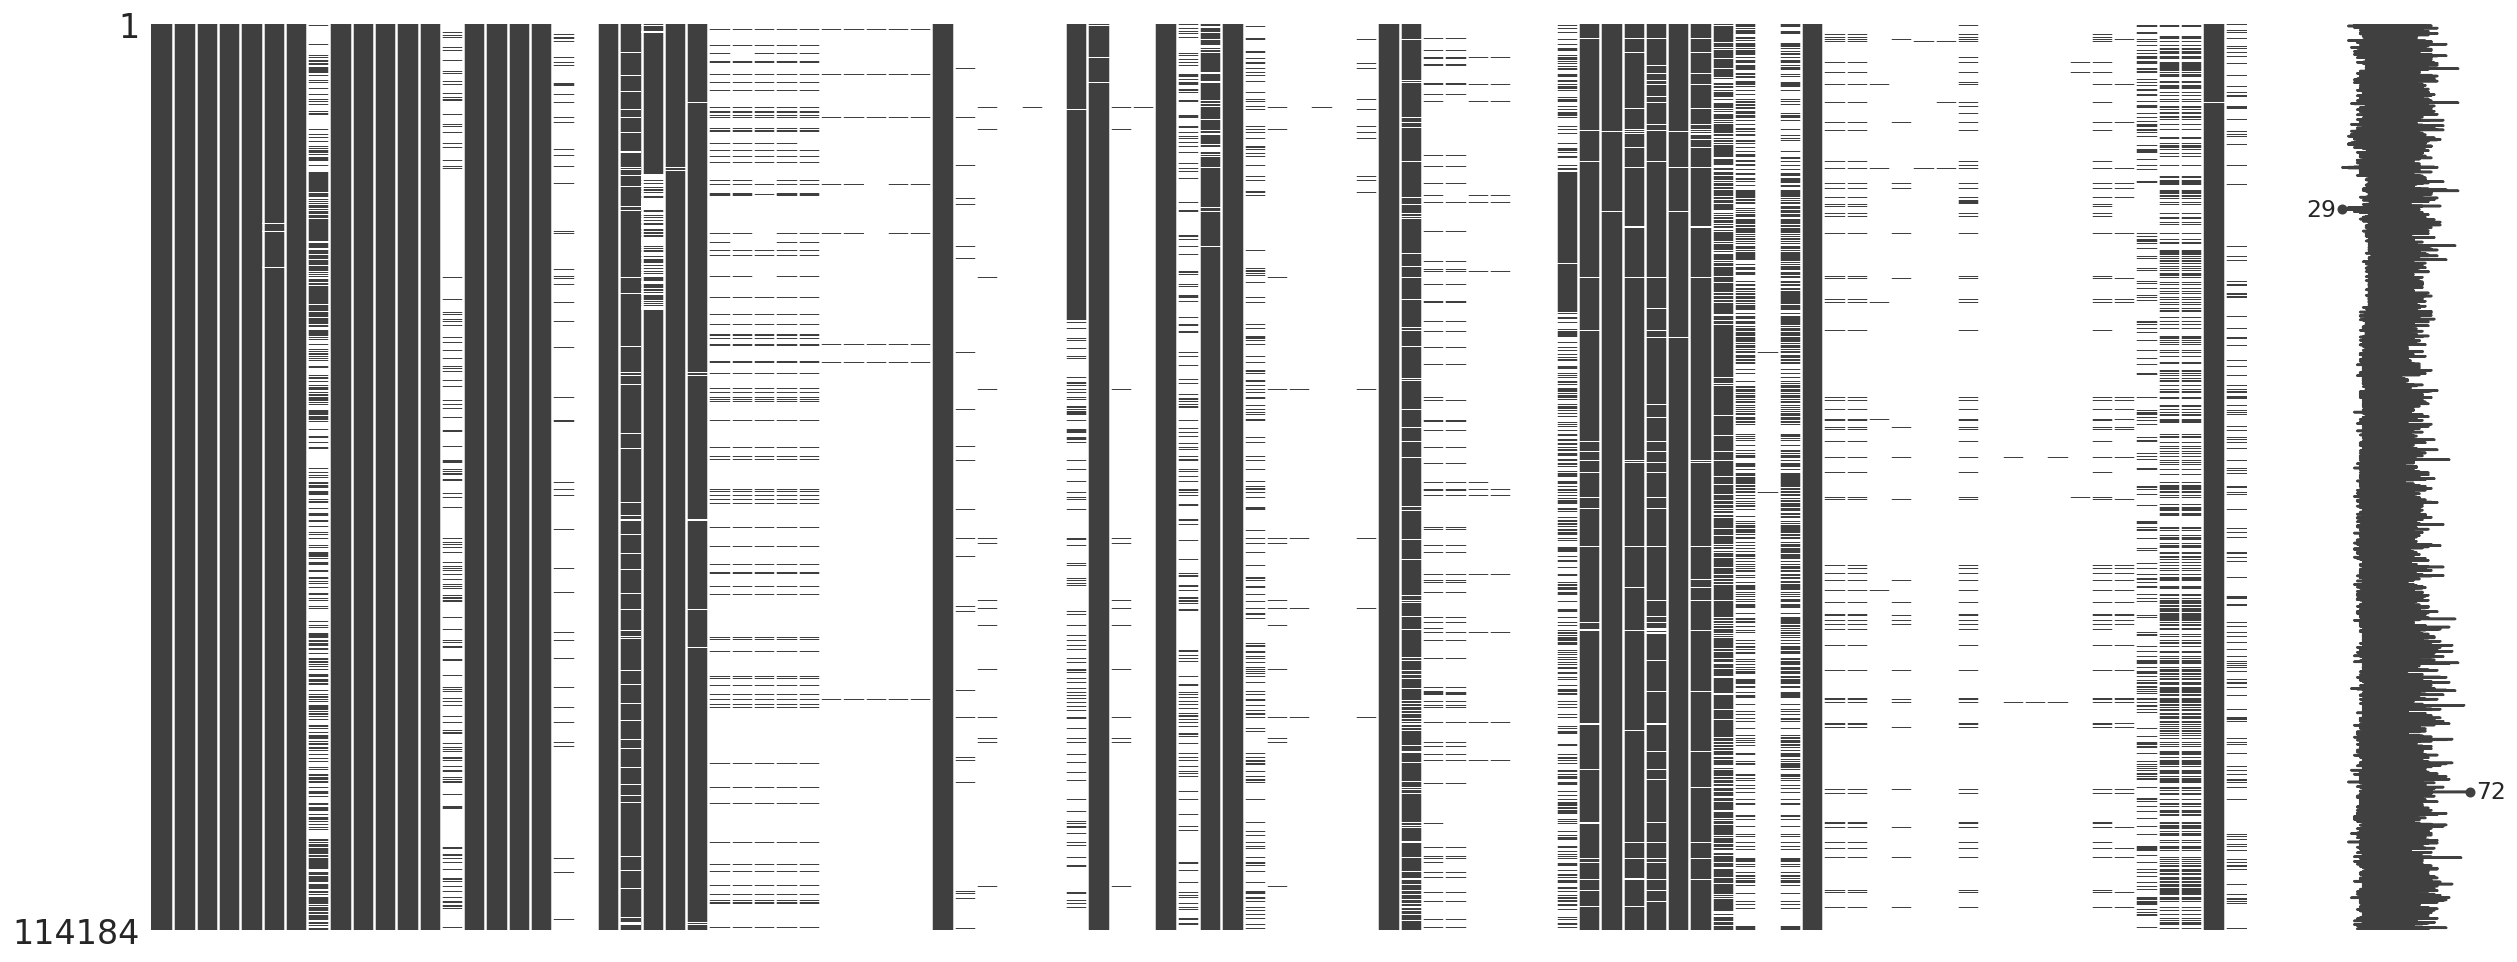

In [10]:
# it may be necessary to right-click and open this image into its own tab
missingno.matrix(df)

#### High-level view
We'll begin with a mile-high view of the density of the data. We see here that some fields are almost always defined, while others are extremely sparse. We also see that the sparsity of many of these sparse fields appear to be perfectly correlated. There is also a hierarchy of values: many are only defined when specific other values are defined.

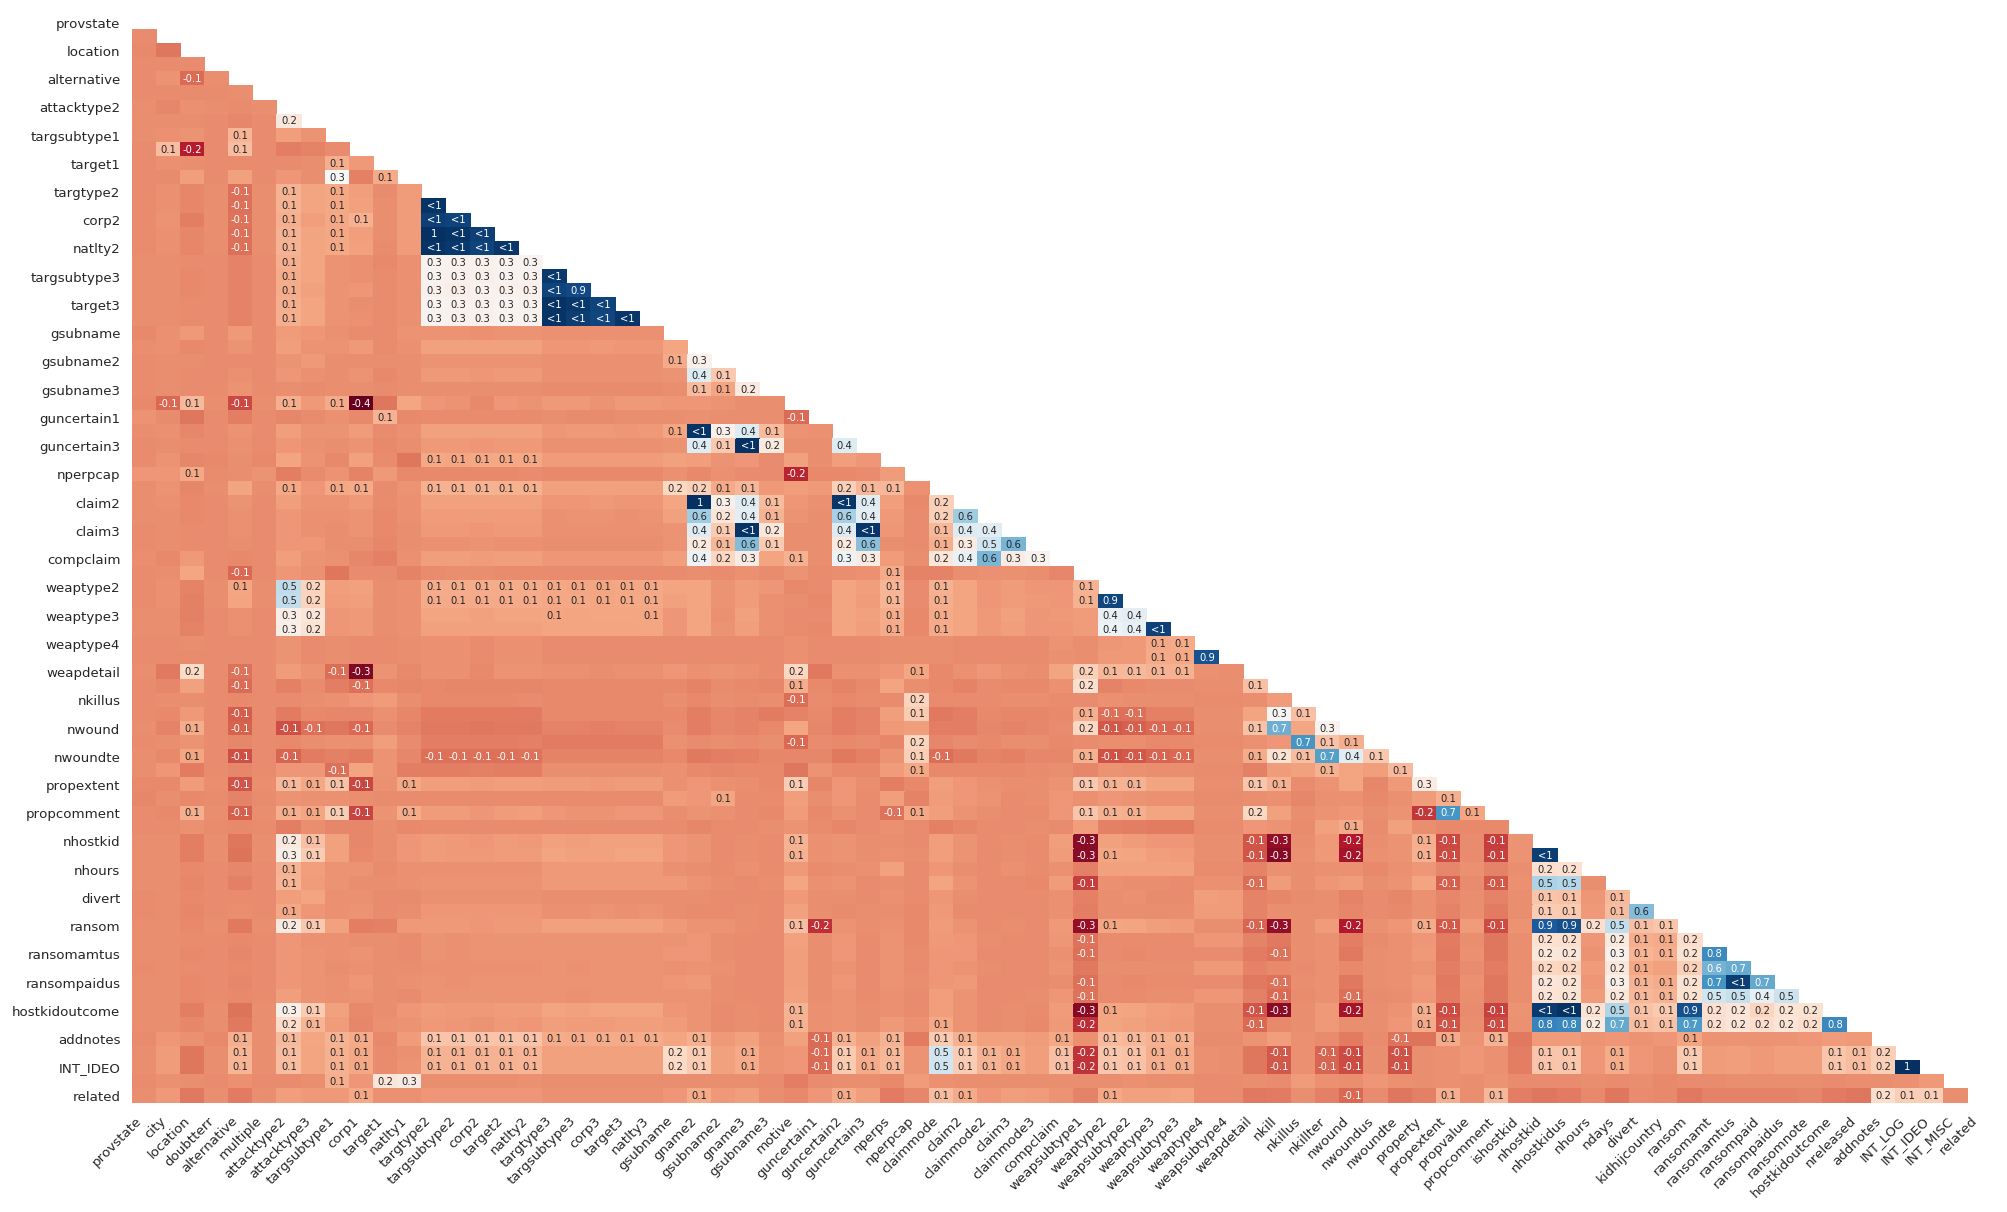

In [11]:
# it may be necessary to right-click and open this image into its own tab
cols_with_na = df.loc[:, df.isna().any(axis=0)]
missingno.heatmap(cols_with_na, fontsize=8)

#### Missing value correlation
Looking at correlations between missing values, we find that there are gruops of variables that have missing-value correlation patterns. Chief among these are the variables describing the target of the incident and those describing ransom/hostage situations. These patterns make sense and are explained in the codebook, but visualizing them here is a good sanity-check and provides a different perspective.

Less visible but equally meaningful are several patterns of correlation between things like weapons type and attack type, fields related to the claiming of an incident and the incident being ideologically international, etc.

Nothing in this correlation matrix jumps out as surpising or exceptionally problematic, though, so we will proceeed without taking any action in response to the nature of the missing values.

# Train-test split
It is good to take a very conservative approach when doing any work that involves data we may eventually want to use to measure out-of-sample statistics on. Accordingly, as soon as data is imported, it is a good idea to perform a train-test split and hold out a large portion of the data for future use. We can always go back and convert some of this held-out data to be training or validation data, but as soon as we start doing EDA or modeling using this data, it becomes impossible to un-learn what we learned from it and make it out-of-sample again, so it's wise to perfrom this split even before EDA.

### The task: predicting identity of perpetrator
Our goal in this analysis is ultimately to predict the identity of those responsible for terrorist attacks. The GTD contains many indicents in which the perpetrator is known, and also many in which the perpetrator is not known. We will ultimately want to "fill in" unknown perpetrators with predictions, but we also want to hold-out some cases in which we know the perpetrator in order to estimate how effective our modeling approach is at determining the perpetrator correctly. We will thus split our data into three pieces: "unknown," "train," and "test."

### Mitigating related incidents
The GTD errs on the side of encoding incidents with multiple components as multiple different incidents, even when the incident could be considered as a single event. If we put some pieces of these incidents into the training set and other pieces into the testing set, we will invalidate the assumption that the testing data is "out of sample" relative to the training data, and we would expect that performance metrics we calculate on this test set will be artificially better than they should be. To mitigate this, we will perform a train-test split by date, ensuring all related incidents that occur in the same date fall in the same set, train or test, and are never be split up across the two. Since related incidents should have the same perpetrator, we are okay to split off the "unknown" set first, before doing the train-test split.

In [12]:
is_unknown = df['gname'].eq('Unknown')
unknown_df = df.loc[is_unknown, :].copy()
known_df = df.loc[~is_unknown, :].copy()
known_df.shape

(54682, 94)

In [13]:
train_set_size = 0.7
all_dates = known_df['date'].unique()
np.random.seed(SEED)
shuffled_order = np.random.permutation(np.arange(all_dates.shape[0]))
split_index = int(train_set_size * all_dates.shape[0])
train_dates = all_dates[shuffled_order[:split_index]]
train_dates.shape

(4588,)

In [14]:
is_in_training_set = known_df['date'].isin(train_dates)
train_df = known_df.loc[is_in_training_set, :].copy()
test_df = known_df.loc[~is_in_training_set, :].copy()
train_df.shape, test_df.shape

((37622, 94), (17060, 94))

In [15]:
print(f'The training set is {train_df.shape[0] / known_df.shape[0]:.2%} of the known dataset.')
print(f'The overall dataset is {train_df.shape[0] / df.shape[0]:.2%} training, '
      f'{test_df.shape[0] / df.shape[0]:.2%} test, and {unknown_df.shape[0] / df.shape[0]:.2%} unknown.')

The training set is 68.80% of the known dataset.
The overall dataset is 32.95% training, 14.94% test, and 52.11% unknown.


# EDA & Feature extraction
We now have imported our dataset and split off a test-set. We are ready to move forward towards understanding our data and learning from it, as well as encoding it into a form suited for prediction.

## Target
First, we'll look into our target variable: the name of the perpetrator group.

In [16]:
# how many unique groups are there?
train_df['gname'].nunique()

1330

Over 1300 different groups is a lot to deal with, and we may not have enough info on some groups to effectively learn their "fingerprint." Let's see if we can narrow things down to a smaller number of important groups that account for most global terrorist activity.

We'll sort by total number of incidents by group and see how many groups we need to include to cover what percent of incidents.

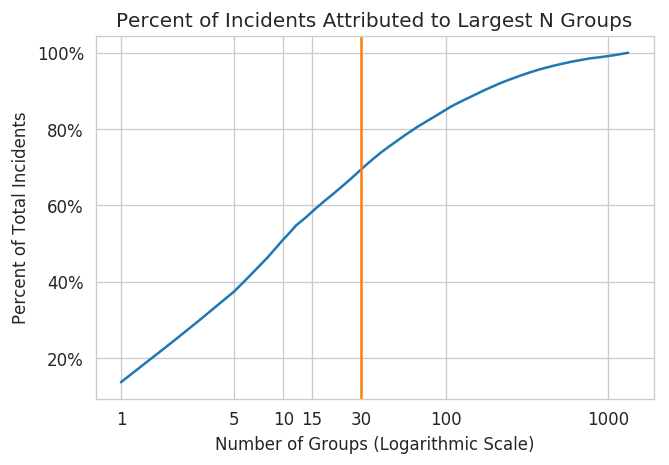

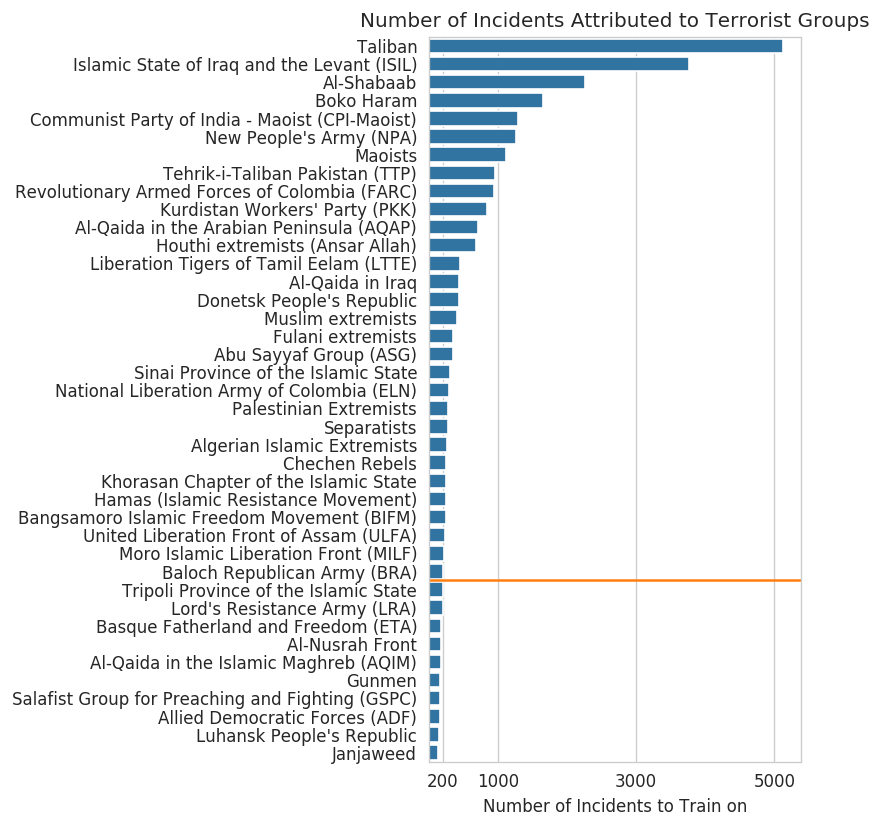

In [17]:
group_percentages = train_df['gname'].value_counts(normalize=True)
gruop_counts = train_df['gname'].value_counts(normalize=False)

# cumulative percentage graph
plt.plot(np.arange(group_percentages.shape[0]) + 1, group_percentages.cumsum())
plt.title('Percent of Incidents Attributed to Largest N Groups')
plt.xlabel('Number of Groups (Logarithmic Scale)')
plt.ylabel('Percent of Total Incidents')
plt.xscale('log')
plt.axvline(30, color=sns.color_palette()[1])
plt.xticks([1, 5, 10, 15, 30, 100, 1000])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.gca().xaxis.set_major_formatter(mtick.ScalarFormatter())
plt.show()

# barplot
plt.figure(figsize=(4, 8))
n_groups_to_barplot = 40
sns.barplot(x=gruop_counts[:n_groups_to_barplot], y=gruop_counts[:n_groups_to_barplot].index,
            color=sns.color_palette()[0])

plt.xlabel('Number of Incidents to Train on')
plt.title('Number of Incidents Attributed to Terrorist Groups')
plt.axhline(29.5, color=sns.color_palette()[1])
plt.xticks([200, 1000, 3000, 5000])
plt.show()

From the first graph, we see that identifying just a few groups will allow us to address a large portion of overall terrorist incidents! We'll stick to the top 30 groups, which will let us address an expected ~70% of terrorist incidents while maintaining at least a few hundred training examples for each group we are seeking to "fingerprint." By encoding the other gruops into an "other" category, we will also end up training our model to learn when the terrorist organization behind an attack is like **not** one of these 30 groups, a useful piece of information in and of itself.

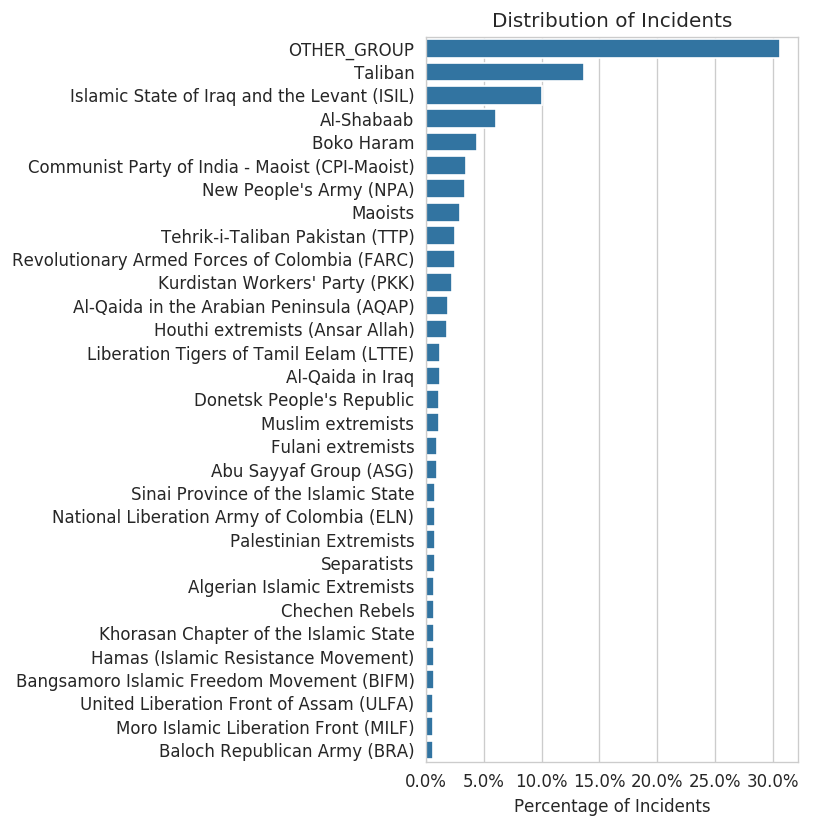

In [18]:
# let's call all other groups "OTHER"
top_groups = gruop_counts[:30].index.tolist()
is_other_group = ~train_df['gname'].isin(top_groups)
train_df.loc[is_other_group, 'gname'] = 'OTHER_GROUP'

is_other_group = ~test_df['gname'].isin(top_groups)
test_df.loc[is_other_group, 'gname'] = 'OTHER_GROUP'


group_percentages = train_df['gname'].value_counts(normalize=True).sort_values(ascending=False)
plt.figure(figsize=(4, 8))
sns.barplot(x=group_percentages, y=group_percentages.index,
            color=sns.color_palette()[0])
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title('Distribution of Incidents')
plt.xlabel('Percentage of Incidents')
plt.show()

## Predictors
Now that we have explored and identified how we will address our target variable, let's go through the other information in the dataset. In my experience, models are often more effective than humans at determining which features are important, so I will avoid running an exhaustive/repetitive list of univariate and bivariate plots and instead simply call out important factors about the kind of predictive information we have.

### Datatypes
The first step will be exploring the kind of data we have. Since we invested a lot of work up front in importing the data well, we can rely on the Pandas datatypes present in our dataframe to tell us the story of what kind of data we have.

In [19]:
# we only have a few datatypes in the dataset
datatypes = train_df.dtypes.apply(lambda dtype: dtype.name).value_counts()
datatypes

category          53
object            22
float64           18
datetime64[ns]     1
dtype: int64

#### Datetime variable
We'll start by examing our one datetime variable: the date of the incident. Here we're just looking to check for any potential time-series trends that could become gotchas.

We notice a sharp uptick in incidents around 2011. We then check to see if this might be caused by increased terrorism by the Taliban and ISIL, and find that these two organizations largely account for this spike in activity.

Since we as humans are able to pick out this pattern, it makes sense that our learning algorithms may benefit from this as well, so we'll put the year of the incident back into the dataset as a numeric value that can be used by learners.

Text(0.5, 1.0, 'Monthly Incidents over Time')

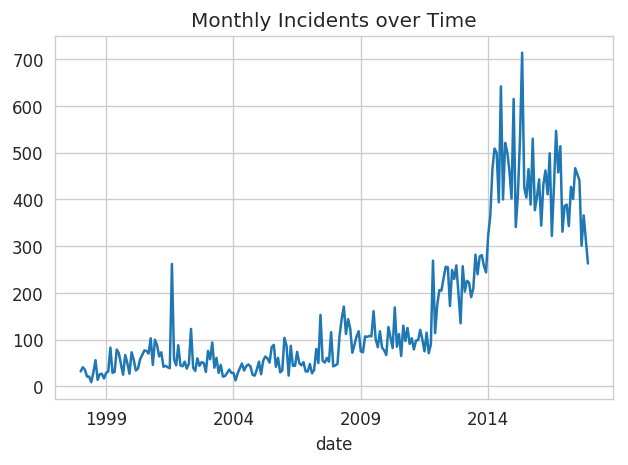

In [20]:
train_df.resample('1M', on='date').size().plot()
plt.title('Monthly Incidents over Time')

Text(0, 0.5, '')

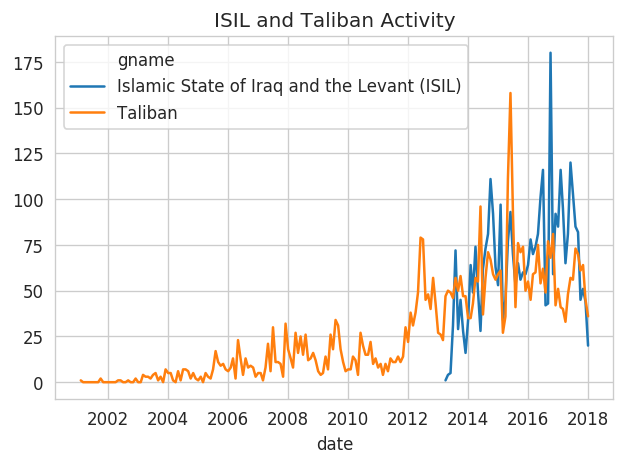

In [21]:
isil_taliban_data = train_df[train_df['gname'].isin(['Islamic State of Iraq and the Levant (ISIL)', 'Taliban'])]
sns.lineplot(x='date', 
             y=0, 
             hue='gname',
             data=(isil_taliban_data
                   .groupby('gname')
                   .resample('1M', on='date')
                   .size()
                   .reset_index())
            )
plt.title('ISIL and Taliban Activity')
plt.ylabel('')

In [22]:
# add year to the dataset as a numeric feature
train_df['incident_year'] = train_df['date'].dt.year.astype('float64')
test_df['incident_year'] = test_df['date'].dt.year.astype('float64')
unknown_df['incident_year'] = unknown_df['date'].dt.year.astype('float64')

#### Continuous variables
Let's now go on to the continuous variables. We'll examine the rates of missing values, look at the overall distributions of these variables, and look for other interesting or concerning patterns.

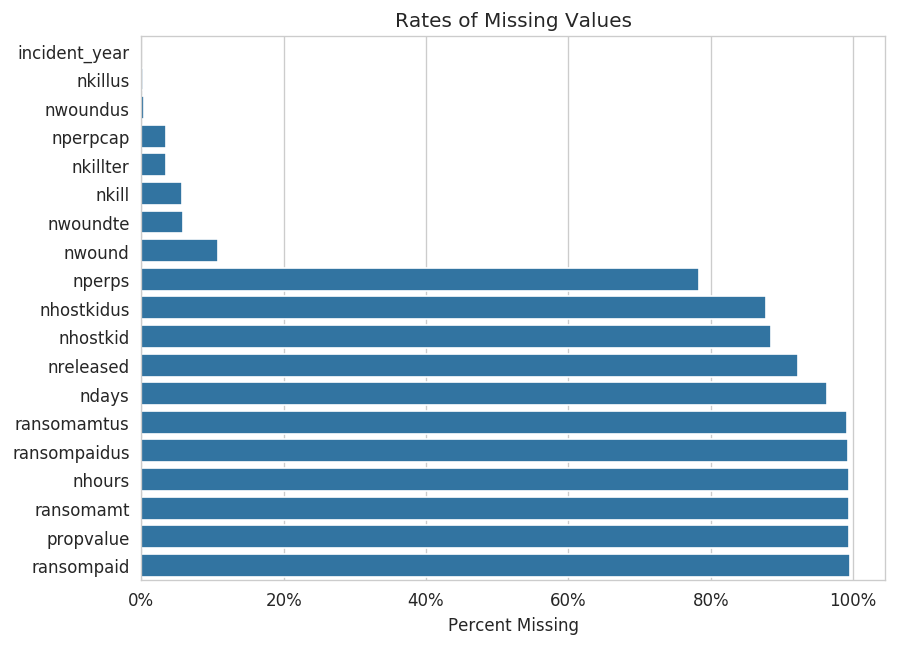

In [23]:
def plot_na_rates(df, figsize=(8, 6)):
    fig = plt.figure(figsize=figsize)
    rates = df.isna().mean().sort_values()
    sns.barplot(x=rates, y=rates.index, color=sns.color_palette()[0])
    plt.title('Rates of Missing Values')
    plt.xlabel('Percent Missing')
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plot_na_rates(train_df.select_dtypes('float64'))

In [24]:
# let's start with the continuous variables and geta quick look at all of them
train_df.describe(percentiles=[.5, .95], include=['float64'])

,nperps,nperpcap,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,propvalue,nhostkid,nhostkidus,nhours,ndays,ransomamt,ransomamtus,ransompaid,ransompaidus,nreleased,incident_year
count,8126.000000,36307.000000,35496.000000,37537.000000,36298.000000,33585.000000,37461.000000,35393.000000,2.080000e+02,4365.000000,4619.000000,232.000000,1355.000000,2.270000e+02,3.040000e+02,1.730000e+02,297.000000,2894.000000,37622.000000
mean,21.648659,0.172556,3.780708,0.016251,0.890077,4.312491,0.021729,0.206001,2.929221e+06,14.617411,0.027062,4.738147,51.419188,4.252133e+06,1.285730e+05,1.781261e+06,195.286195,7.857636,2012.092472
std,106.986132,3.086123,15.864919,0.508980,5.561423,19.452498,0.678326,2.161714,2.527204e+07,115.975464,0.248694,5.669335,155.762189,2.002138e+07,8.097967e+05,2.090813e+07,2843.124352,65.710132,4.891533
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1998.000000
50%,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.940000e+04,2.000000,0.000000,2.000000,6.000000,9.928800e+04,0.000000e+00,0.000000e+00,0.000000,1.000000,2014.000000
95%,100.000000,0.000000,15.000000,0.000000,4.000000,18.000000,0.000000,0.000000,6.268445e+06,41.000000,0.000000,18.000000,258.300000,1.740825e+07,0.000000e+00,1.316261e+06,0.000000,21.000000,2017.000000
max,5000.000000,406.000000,1570.000000,60.000000,500.000000,1001.000000,77.000000,200.000000,3.500000e+08,5350.000000,6.000000,24.000000,1941.000000,2.000000e+08,6.600000e+06,2.750000e+08,48000.000000,2769.000000,2017.000000


In [25]:
# another way to see this more intuitively is via histograms
def plot_distributions(df, kind='continuous', n_col=4, take_log=False):
    plt.figure(figsize=(8, 20))
    n_plot = df.shape[1]
    n_row = int(np.ceil(n_plot / n_col))
    for i, column in enumerate(df):
        ax = plt.subplot(n_row, n_col, i+1)
        if kind == 'continuous':
            if take_log:
                df[column].dropna().apply(np.log1p).plot(kind='hist', ax=ax)
            else:
                df[column].dropna().plot(kind='hist', ax=ax)
        else:
            val_counts = df[column].dropna().value_counts(normalize=True)
            sns.barplot(val_counts.index, val_counts, ax=ax)
        plt.title(column, pad=-12)
        plt.ylabel('')
        # hide ytick labels
        ticks, labels = plt.yticks()
        plt.yticks(ticks=ticks, labels=[])

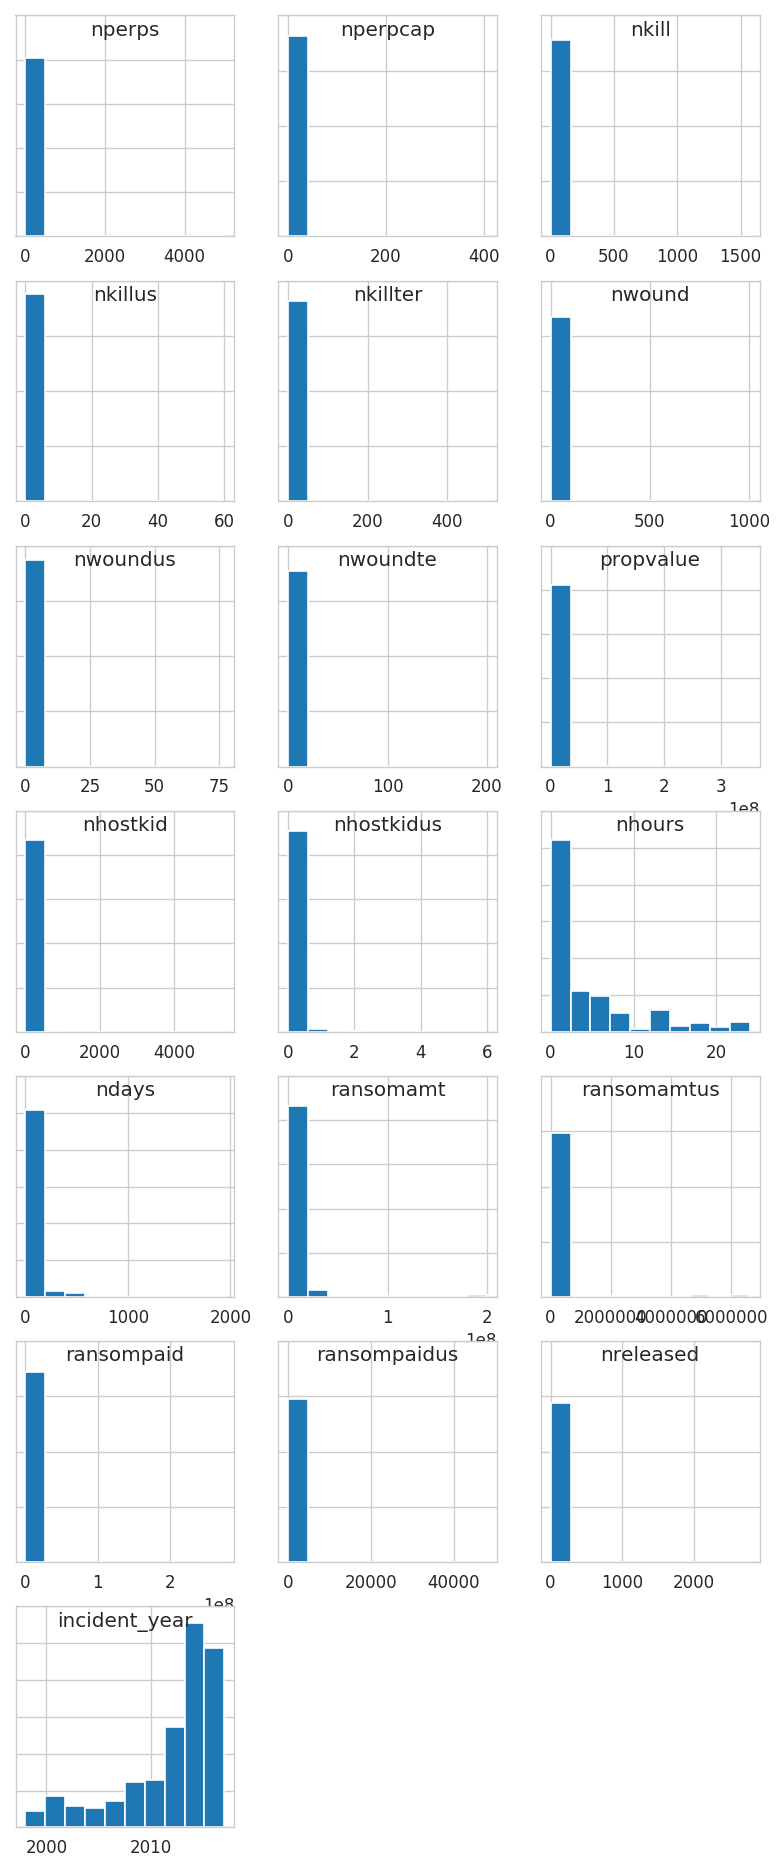

Same as above, but on the log of values.


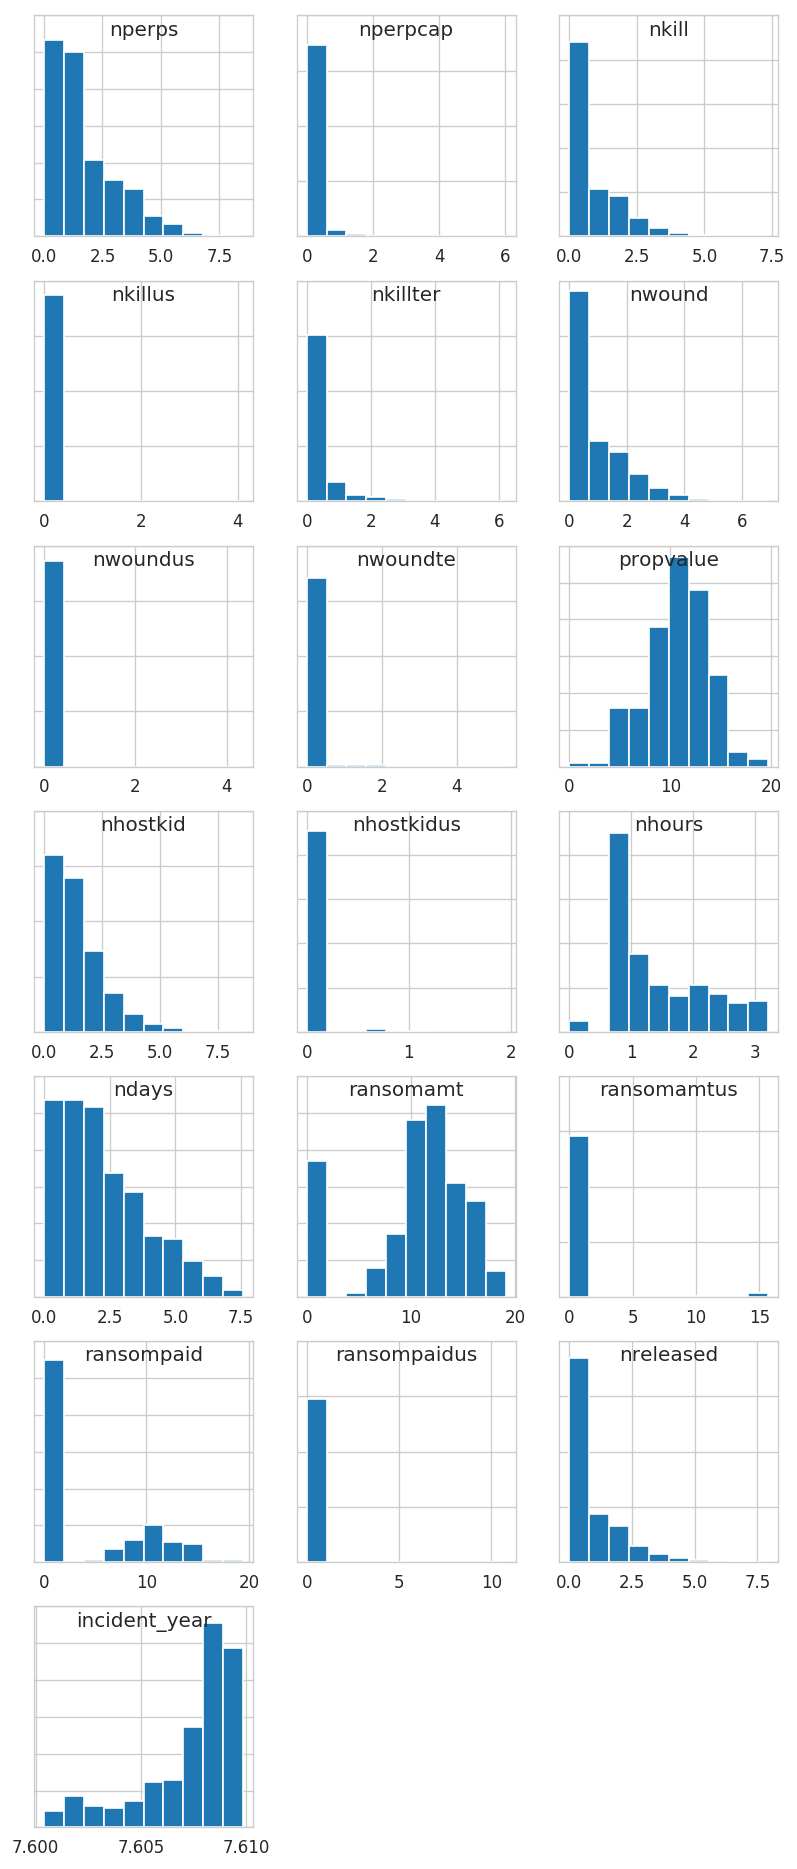

In [26]:
plot_distributions(train_df.select_dtypes('float64'), n_col=3)
plt.show()
print('='*80)
print('Same as above, but on the log of values.')
plot_distributions(train_df.select_dtypes('float64'), n_col=3, take_log=True)

#### Continuous variables: takeaways
We see that some of our continuous variables are almost always defined, while others are almost always undefined. Considering which variables they are, this makes perfect sense. For example, the amount of ransom demanded and paid is not defined for any kind of terrorist incident that is not a ransom. However, for the purpose of using this information to run machine learning, this pattern can be problematic. Many learning algorithms are not designed to handle missing values, forcing us to encode these values numerically. For all of the continuous variables here, a value of "0" would make sense, but it would also hurt the data's ability to be predictive. When the amount of ransom paid is only "0" when the indicent is actually a ransom, a model can learn to associate this value with a perpatrator that often demands ransoms which end up going upaid. When we fill all missing values with zero, our model can no longer pick up on this "fingerprint." Imputation is the typical solution to this type of problem, but it breaks down when the percentage of rows that are missing values is very large, as it is in this dataset.

To address this issue, we will in general tend toward model classes which can handle these missing values elegantly (like tree-based learners, for which we can encode missing values as a sentinel value like -99 or use built-in NaN-handling in some libraries) or we will omit these mostly-missing predictors from our model inputs when training models that cannot elegantly handle missing values.

Beyond missing values, we also see that many of our continuous variables have extremely imbalanced or skewed distributions. We may run into a few issues using linear models with this type of data if we don't apply any nonliner transformations to the data.

#### Categorical variables
Next, let's look at our categorical variables.

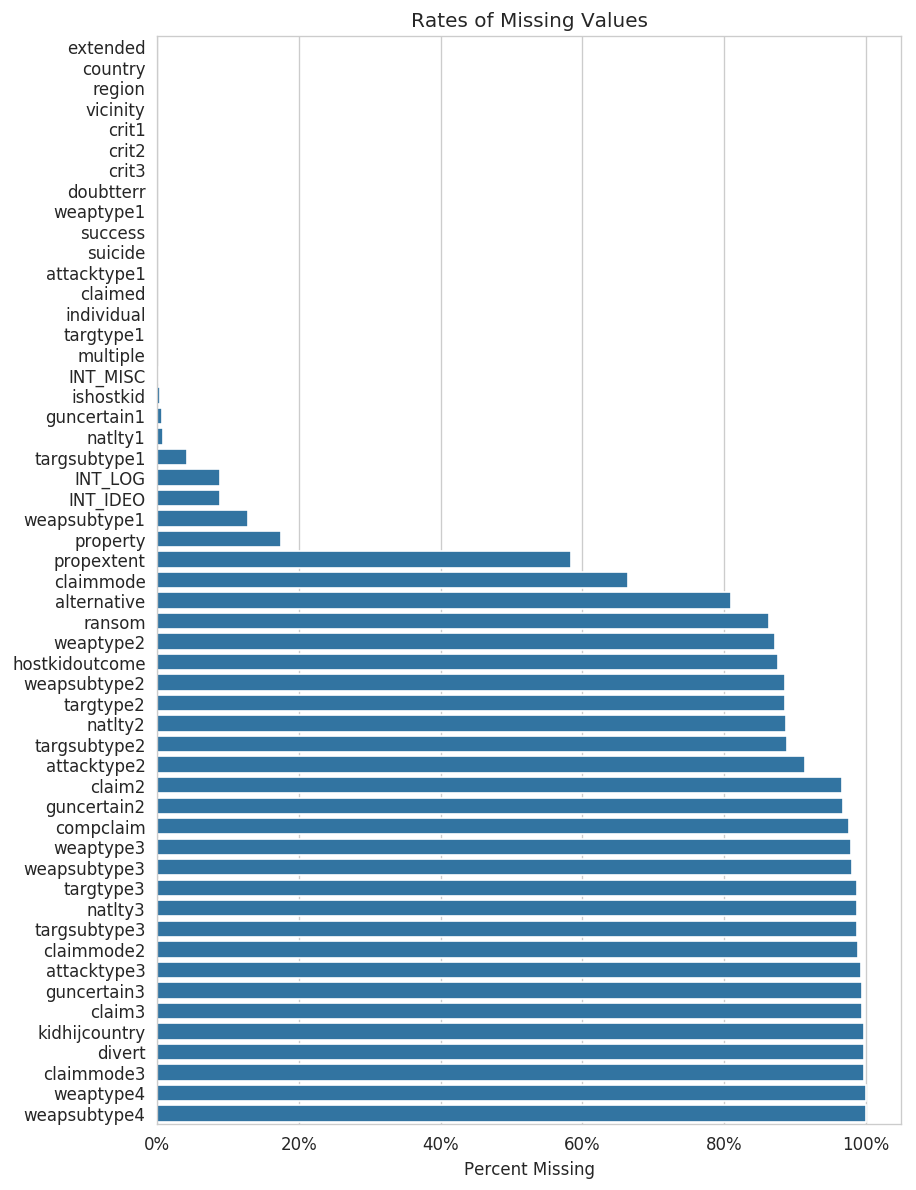

In [27]:
plot_na_rates(train_df.select_dtypes(include=['category']), figsize=(8,12))

Here we see that the majority case is that there is not a second or third weapon type, claim, target, perpetrator, etc. We will thus elect to simplify this type of information by simply adding a boolean flag for each of these cases to indicate whether there is extra information that is truncated.

An alternative approach we can consider is to one-hot encode all of these types of variables and then "overlap" them. In this case, something like `weapontype` would be represented as a vector of boolean values, and it would be possible for up to four of these values to be true simultaneously.

In [28]:
multi_field_stems = [x[:-1] for x in train_df.select_dtypes('category') if '2' in x and x != 'crit2']
for stem in multi_field_stems:
    fields_to_remove = [x for x in train_df.select_dtypes('category')
                        if stem in x and '1' not in x and x not in ['claimed', 'compclaim']]
    for df in (unknown_df, train_df, test_df):
        df[stem + '_has_other_levels'] = df[fields_to_remove].any(axis=1)
        df.drop(columns=fields_to_remove, inplace=True)

In [29]:
# how often are there other levels?
train_df.select_dtypes('bool').mean()

attacktype_has_other_levels     0.086226
targtype_has_other_levels       0.113923
targsubtype_has_other_levels    0.111105
natlty_has_other_levels         0.112248
guncertain_has_other_levels     0.009223
claim_has_other_levels          0.336319
claimmode_has_other_levels      0.000000
weaptype_has_other_levels       0.128861
weapsubtype_has_other_levels    0.114906
dtype: float64

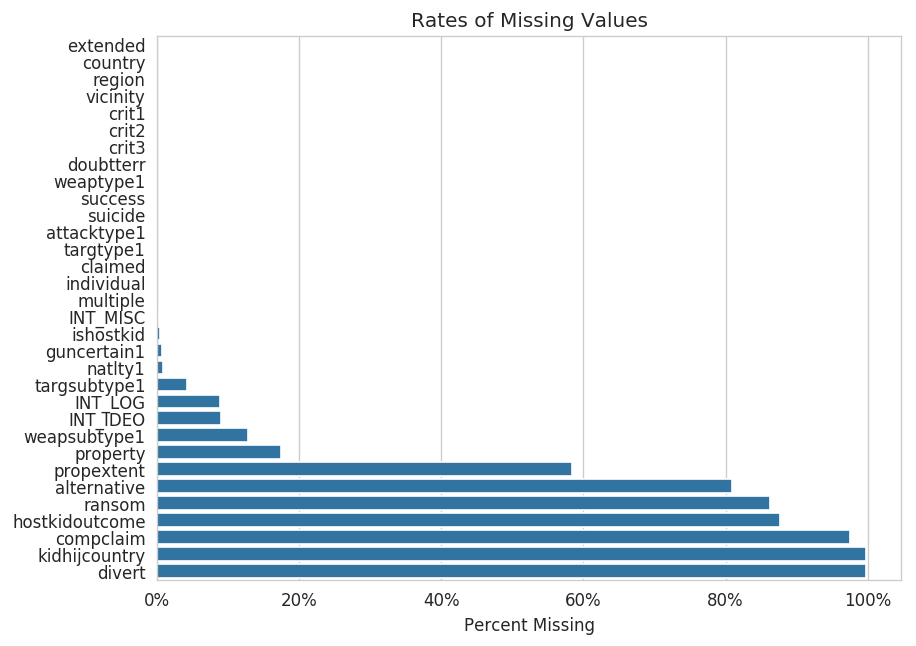

In [30]:
plot_na_rates(train_df.select_dtypes(include=['category']))

In [31]:
# let's look at number of unique values
train_df.select_dtypes(include=['category']).nunique(dropna=False).sort_values(ascending=False)

natlty1           160
country           136
targsubtype1      112
divert             36
kidhijcountry      35
weapsubtype1       31
targtype1          22
region             12
weaptype1          12
attacktype1         9
hostkidoutcome      8
alternative         6
ransom              4
propextent          4
vicinity            3
multiple            3
INT_MISC            3
INT_IDEO            3
guncertain1         3
claimed             3
compclaim           3
property            3
ishostkid           3
INT_LOG             3
individual          2
suicide             2
success             2
doubtterr           2
crit3               2
crit2               2
crit1               2
extended            2
dtype: int64

Country and nationality have very high cardinality, so let's replace them with an engineered feature indicating whether the country of the attack and the nationality of the target were the same or not.

In [32]:
for df in (unknown_df, train_df, test_df):
    df['country_nationalty_same'] = df['natlty1'].astype('str').eq(df['country'].astype('str'))
    df.drop(columns=['natlty1', 'country'], inplace=True)

Additionally, two of these variables have a lot of different levels and are mostly NaN: `kidhijcountry` and `divert`. Unfortunately these types of variables can pose an overfitting issue. An elegant solution is to implement some sort of binning logic to combine levels of these variables and reduce their cardinality, the quick fix used here is just to drop these variables from the set of predictors.

We also should drop "type" fields where there is a higher-specificity "subtype" field associated with it.

In [33]:
categorical_fields_to_drop = ['kidhijcountry', 'divert']
type_fields_to_drop = ['weaptype1', 'targtype1']
for df in (unknown_df, train_df, test_df):
    df.drop(columns=categorical_fields_to_drop + type_fields_to_drop, inplace=True)

In [34]:
train_df.shape

(37622, 78)

#### Text variables
Building at least some sort of basic feature extraction rules for the text-valued variables present in this dataset would likely create additional features useful for feeding into our models. Often a bag-of-keywords approach can allow us to extract a lot of predictive information from text fields, for example. For simplicity we will ignore these variables for now, though, since they are not directly usable without some amount of keyword matching or NLP work.

Additionally, there is a data-leakage concern associated with these features, as the group responsible for an attack may be mentioned in some of the text fields. If we want to use these fields, we must be very careful about properly scrubbing all label information out of those fields.

In [35]:
text_fields_to_drop = train_df.select_dtypes('object').columns.tolist()
text_fields_to_drop.remove('gname')
for df in (unknown_df, train_df, test_df):
    df.drop(columns=text_fields_to_drop, inplace=True)

In [36]:
train_df.shape

(37622, 57)

# Next steps: modeling
Now that we have our data imported, explored, and processed, the next step is to train our models and get into the real machine learning! Given how long this notebook has grown in just the importing and EDA steps, I'm going to wrap up this notebook here and pick up the modeling work in a fresh noebook: `2_global_terrorism_ml`.

In [37]:
# encode group name as categorical for ML purposes
train_df['gname'] = train_df['gname'].astype('category')
test_df['gname'] = test_df['gname'].astype(train_df['gname'].dtype)

# write the processed data to disk
unknown_df.to_pickle('../data/processed/unknown_df.pkl')
train_df.to_pickle('../data/processed/train_df.pkl')
test_df.to_pickle('../data/processed/test_df.pkl')